In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import polars.selectors as cs
from typing import cast

from data import load_data
from config import Species, TARGET, FEATURES_DESCRIPTION

# Load data for the given species
all_dfs = []

for species in cast(list[Species], ["pine", "spruce", "beech", "oak"]):
    print(f"Loading data for species: {species}")
    df = load_data(species).with_columns(pl.lit(species).alias("species"))

    # Compute number of plots (plot_id) and trees (tree_id)
    for grouping in ["plot_id", "tree_id"]:
        num_plots = df.group_by(grouping).len().select(pl.len()).item()
        num_plots_with_defoliation = (
            df.filter(pl.col("num_defoliation_obs") > 0)
            .group_by(grouping)
            .len()
            .select(pl.len())
            .item()
        )
        num_plots_with_deposition = (
            df.filter(~pl.all_horizontal(cs.starts_with("dep_").is_null()))
            .group_by(grouping)
            .len()
            .select(pl.len())
            .item()
        )
        num_plots_with_soil = (
            df.filter(~pl.all_horizontal(cs.starts_with("ss_").is_null()))
            .group_by(grouping)
            .len()
            .select(pl.len())
            .item()
        )

        print(f" `- # of {grouping}:")
        print(f"    `- in total : {num_plots}")
        print(f"    `- w/ defoliation data: {num_plots_with_defoliation}")
        print(f"    `- w/ deposition data: {num_plots_with_deposition}")
        print(f"    `- w/ soil data: {num_plots_with_soil}")
        print()

    all_dfs.append(df)

df = pl.concat(all_dfs, how="vertical")

Loading data for species: pine
 `- # of plot_id:
    `- in total : 146
    `- w/ defoliation data: 146
    `- w/ deposition data: 135
    `- w/ soil data: 63

 `- # of tree_id:
    `- in total : 5515
    `- w/ defoliation data: 5515
    `- w/ deposition data: 4802
    `- w/ soil data: 3064

Loading data for species: spruce
 `- # of plot_id:
    `- in total : 143
    `- w/ defoliation data: 143
    `- w/ deposition data: 125
    `- w/ soil data: 89

 `- # of tree_id:
    `- in total : 7833
    `- w/ defoliation data: 7833
    `- w/ deposition data: 7054
    `- w/ soil data: 4860

Loading data for species: beech
 `- # of plot_id:
    `- in total : 80
    `- w/ defoliation data: 80
    `- w/ deposition data: 76
    `- w/ soil data: 53

 `- # of tree_id:
    `- in total : 3726
    `- w/ defoliation data: 3726
    `- w/ deposition data: 3304
    `- w/ soil data: 2719

Loading data for species: oak
 `- # of plot_id:
    `- in total : 55
    `- w/ defoliation data: 55
    `- w/ deposition dat

In [3]:
print("Number of rows in total:", df.height)
height = df.filter(pl.any_horizontal(cs.starts_with("dep_").is_not_null())).height
print("Number of rows with defoliation data:", height)
height = df.filter(pl.any_horizontal(cs.starts_with("ss_").is_not_null())).height
print("Number of rows with soil solution data:", height)

Number of rows in total: 33450
Number of rows with defoliation data: 30060
Number of rows with soil solution data: 20505


In [4]:
with pl.Config(
    tbl_formatting="MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_rows=-1,
    tbl_width_chars=200,
    fmt_str_lengths=200,
) as cfg:
    print(
        pl.from_dicts(
            [
                {**{"feature": feature}, **descr}
                for feature, descr in FEATURES_DESCRIPTION.items()
            ]
        )
    )

shape: (68, 4)
| feature            | description                                  | level | unit    |
|--------------------|----------------------------------------------|-------|---------|
| defoliation_max    | Maximum defoliation of the growth period     | tree  | %       |
| defoliation_min    | Minimum defoliation of the growth period     | tree  | %       |
| defoliation_mean   | Mean defoliation of the growth period        | tree  | %       |
| defoliation_median | Median defoliation of the growth period      | tree  | %       |
| social_class_min   | Minimum social class of the growth period    | tree  | null    |
| plot_latitude      | Latitude of the plot                         | plot  | °       |
| plot_longitude     | Longitude of the plot                        | plot  | °       |
| plot_slope         | Slope of the plot                            | plot  | %       |
| plot_orientation   | Orientation of the plot                      | plot  | null    |
| plot_altitude  

In [5]:
# Check that data contains all features
missing_features = set(FEATURES_DESCRIPTION.keys()) - set(df.columns)
if missing_features:
    raise ValueError(
        f"Data is missing the following features: {missing_features}. "
        "Please check the data loading process."
    )

Distribution of the number of trees per plot:
# min = 1
# max = 759
# mean = 97.80701754385964
# of single-tree plots = 4


Text(0.5, 1.0, 'Distribution of the number of trees per plot')

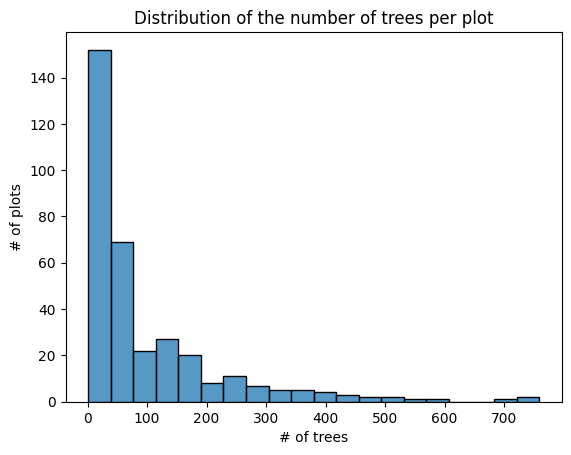

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the number of trees per plot
print("Distribution of the number of trees per plot:")
num_trees = df.group_by("plot_id").agg(pl.count("tree_id").alias("num_trees"))

print(f"# min = {num_trees['num_trees'].min()}")
print(f"# max = {num_trees['num_trees'].max()}")
print(f"# mean = {num_trees['num_trees'].mean()}")
print(f"# of single-tree plots = {len(num_trees.filter(num_trees['num_trees'] == 1))}")

_ = sns.histplot(num_trees["num_trees"], bins=20)
plt.xlabel("# of trees")
plt.ylabel("# of plots")
plt.title("Distribution of the number of trees per plot")

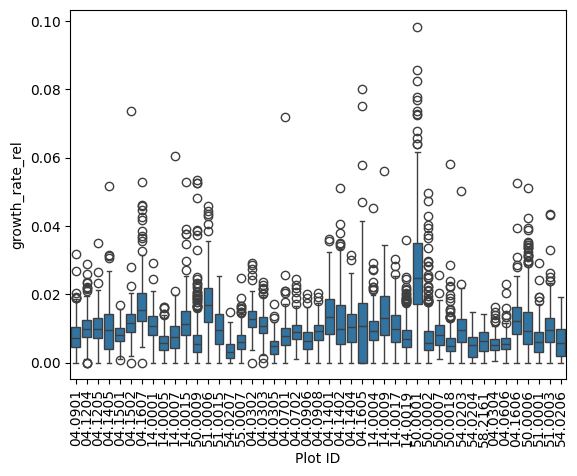

In [7]:
# Plot box plots of target variable by plot_id

# Keep only plots with at least 10 trees
data = df.with_columns(
    pl.col("tree_id").n_unique().over("plot_id").alias("num_trees")
).filter(pl.col("num_trees") >= 100)
sns.boxplot(x="plot_id", y=TARGET, data=data.to_pandas())
plt.xlabel("Plot ID")

# Vertical label for x-axis
_ = plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'East'),
  Text(1, 0, 'Flat'),
  Text(2, 0, 'North'),
  Text(3, 0, 'North-east'),
  Text(4, 0, 'North-west'),
  Text(5, 0, 'South'),
  Text(6, 0, 'South-east'),
  Text(7, 0, 'South-west'),
  Text(8, 0, 'West')])

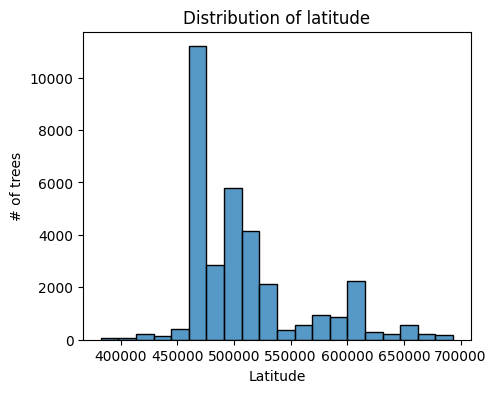

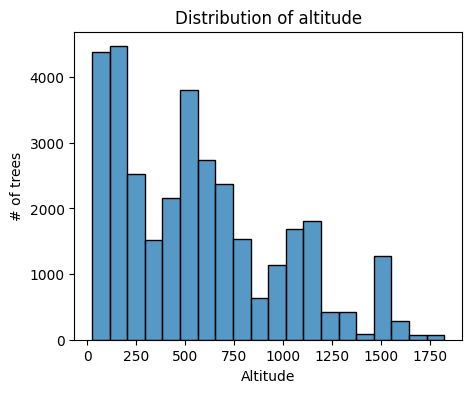

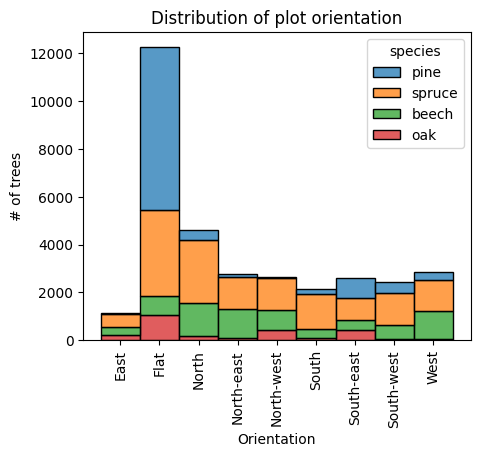

In [8]:
# Plot distribution of trees of latitude and longitude
plt.figure(figsize=(5, 4))
sns.histplot(df["plot_latitude"], bins=20)
plt.xlabel("Latitude")
plt.ylabel("# of trees")
plt.title("Distribution of latitude")

# Plot distribution of trees of altitudes
plt.figure(figsize=(5, 4))
sns.histplot(df["plot_altitude"], bins=20)
plt.xlabel("Altitude")
plt.ylabel("# of trees")
plt.title("Distribution of altitude")

# Plot distributions of trees across plot orientation for each species
plt.figure(figsize=(5, 4))
sns.histplot(
    data=df.to_pandas(),
    x="plot_orientation",
    bins=20,
    hue="species",
    multiple="stack",
    stat="count",
)
plt.xlabel("Orientation")
plt.ylabel("# of trees")
plt.title("Distribution of plot orientation")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'East'),
  Text(1, 0, 'Flat'),
  Text(2, 0, 'North'),
  Text(3, 0, 'North-east'),
  Text(4, 0, 'North-west'),
  Text(5, 0, 'South'),
  Text(6, 0, 'South-east'),
  Text(7, 0, 'South-west'),
  Text(8, 0, 'West')])

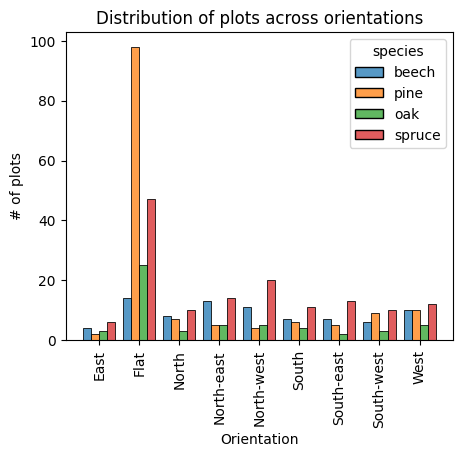

In [9]:
# plot distribution of plots across orientations
plt.figure(figsize=(5, 4))
sns.histplot(
    data=df.group_by("species", "plot_id").agg(
        pl.first("plot_orientation").alias("plot_orientation")
    ),
    x="plot_orientation",
    bins=20,
    hue="species",
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Orientation")
plt.ylabel("# of plots")
plt.title("Distribution of plots across orientations")
plt.xticks(rotation=90)

In [10]:
pl.read_parquet("./data/tidy/cpf-level2_growth-periods_with-cc.parquet").select(
    pl.selectors.contains("dep_")
).describe()

statistic,dep_ph,dep_cond,dep_k,dep_ca,dep_mg,dep_na,dep_n_nh4,dep_cl,dep_n_no3,dep_s_so4,dep_alk,dep_n_tot,dep_doc,dep_al,dep_mn,dep_fe,dep_p_po4,dep_cu,dep_zn,dep_hg,dep_pb,dep_co,dep_mo,dep_ni,dep_cd,dep_s_tot,dep_c_tot,dep_n_org,dep_p_tot,dep_cr,dep_n_no2,dep_hco3,dep_don
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",35886.0,35870.0,35886.0,35886.0,35733.0,35886.0,35886.0,35886.0,35886.0,35886.0,29627.0,31657.0,22433.0,21990.0,23850.0,21737.0,20674.0,12880.0,13280.0,1213.0,10813.0,5910.0,3807.0,11131.0,9427.0,10446.0,2766.0,4814.0,7436.0,1705.0,1677.0,0.0,0.0
"""null_count""",4060.0,4076.0,4060.0,4060.0,4213.0,4060.0,4060.0,4060.0,4060.0,4060.0,10319.0,8289.0,17513.0,17956.0,16096.0,18209.0,19272.0,27066.0,26666.0,38733.0,29133.0,34036.0,36139.0,28815.0,30519.0,29500.0,37180.0,35132.0,32510.0,38241.0,38269.0,39946.0,39946.0
"""mean""",5.407524,36.583677,1.866737,1.560964,0.368997,0.967277,1.012056,1.682775,0.882058,1.323786,71.090724,2.466191,7.004473,-0.052669,1.183176,-0.069266,6.018317,8.817646,52.770893,-0.177801,3.90171,0.077312,-0.302746,0.093992,-0.132486,0.552049,17.95959,0.483265,-0.8231,-0.971985,-0.61972,null,null
"""std""",0.471858,25.080323,1.85059,2.336667,0.727221,2.622472,0.877056,2.037721,0.746037,1.859206,87.137449,1.62615,4.015558,1.830284,7.551762,2.07149,58.794502,8.799356,96.640908,0.577926,5.89091,1.199678,0.768772,1.380219,0.779616,0.35987,18.644793,0.317606,0.205233,0.049363,0.22715,null,null
"""min""",1.780556,5.978632,-0.464073,-0.730747,-0.466667,-0.241667,-0.425675,-0.620009,-0.883219,-0.231978,-1.0,0.246659,1.105,-1.0,-0.949462,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.043837,2.181186,-0.668417,-1.0,-1.0,-0.883624,null,null
"""25%""",5.083,20.889505,0.913101,0.621215,0.135662,0.333699,0.412821,0.683375,0.403882,0.495194,24.507365,1.287643,4.326379,-0.766684,-0.290945,-0.85022,-0.9125,3.277,17.990909,-1.0,0.403201,-1.0,-1.0,0.0,-1.0,0.290754,7.697174,0.291831,-0.962697,-1.0,-0.856286,null,null
"""50%""",5.407497,31.395833,1.537292,1.053104,0.247482,0.629821,0.877453,1.153652,0.799294,0.895323,47.849321,2.430003,6.4825,-0.182083,0.013697,-0.237062,-0.564278,7.063389,28.474786,0.1,2.497411,-0.150625,-1.0,0.0,0.042,0.472978,9.239495,0.445352,-0.923373,-0.978723,-0.680255,null,null
"""75%""",5.723326,44.247241,2.259123,1.70471,0.462333,1.02359,1.369364,1.896677,1.186536,1.329388,91.855241,3.18177,8.428166,0.048835,0.079363,0.023474,0.109986,9.78533,50.328125,0.28055,4.394732,0.4795,0.450621,0.0,0.491572,0.769267,13.51296,0.605483,-0.781279,-0.967949,-0.437881,null,null
"""max""",7.226326,336.414773,22.60984,40.594384,17.325148,69.99354,9.170082,33.287353,5.716804,16.34634,952.928927,18.620833,39.837866,22.733963,82.1278,56.972317,909.096103,58.416249,999.0,0.434,38.935417,3.155013,1.075,18.739549,2.618182,1.974109,68.358333,4.333333,-0.17171,-0.752,-0.19213,null,null
